# Control Flow

In this notebook we'll look at a few tricks to deal with different [control flow](https://en.wikipedia.org/wiki/Control_flow) types in meshed. 

There are arguments against introducing (more than the strict necessary) control-flow types as well as alternatives to solve problems where they show up (see [this dicussion](https://github.com/i2mint/meshed/discussions/59#:~:text=Appendix%3A%20Why%20should%20control%20flow%20constructs%20like%20if%2Dthen%2Delse%20and%20switch%2Dcase%20be%20avoided%20when%20possible%3F)).

Problem patterns often show up where control flow would be useful to solve the problem easily, so we should address these, in one way or another.



<img src="https://www.scientecheasy.com/wp-content/uploads/2019/10/control-flow.png" alt="Three types of control flow" width=400/>

Some links:
* [Multi-channel based segmenter](https://github.com/i2mint/creek/discussions/8)
* [DAGX, with CondNodes](https://github.com/i2mint/meshed/discussions/59)

# Examples

Here we'll look at concrete examples that represent frequent problem patterns pop up in "real life". In reality, these problem patterns are really solution patterns that one is used to applying to problems when writing software. Namely:
* Conditional execution, which includes:
  * only executing something if specific conditions are met
  * chosing what to execute according to conditions (which is really a generalization of the previous case)
* changing (and maintaining) states

Look out for both these themes in the following example.

## Turning a recording on and off


We have two streams:
* `audio`, an audio stream
* `plc`, a stream that indicates whether some [momentary switch (button)](https://learn.sparkfun.com/tutorials/button-and-switch-basics/momentary-switches) was pressed

What we want to do is write a program that will take these two streams, start recording the audio when the `plc` "button" is pressed, then stop the recording when the button is pressed again, and so on continuously. 


This is a take on the [Multi-channel based segmenter](https://github.com/i2mint/creek/discussions/8) problem, but in the segmenter problem, we boiled it down to creating a stream of tagged intervals, assuming these could be used, via a sufficiently large buffer, to extract and store the signals of interest. 

Here, though, we will not take the "buffer+segment" approach, but instead use some recording state that will be toggled by the `plc`. 

Let's first take a simple form of the problem, assuming the audio and plc streams are in sync; `audio` is a stream of chunks and `plc` an (aligned) stream of `0`s and `1`s (the latter indicating a button was pressed). 
This means we need no timestamp (for now). 

Also, we'll add another object: a `store`, our facade to our storage backend.


### A simple solution

In [6]:
def mk_test_objects():
    import itertools
    from typing import Callable
    from functools import partial
    from slang import fixed_step_chunker
    audio = range(100)
    audio_chk_size = 5
    audio_chks = list(fixed_step_chunker(audio, chk_size=audio_chk_size))
    plc_values = [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]

    return audio_chks, plc_values

def conditional_recording_1(audio_chks, plc_values, chks_store):
    is_recording = False
    for chk, plc in zip(audio_chks, plc_values):
        if plc == 1:
            chks_store.append(chk)  # no matter what, record this chunk
            is_recording = not is_recording  # toggle recording state
        elif is_recording:
            chks_store.append(chk)  # continue recording
        # else:  # do nothing (neither record, nor toggle recording state)

# Test this:

from pprint import pprint

audio_chks, plc_values = mk_test_objects()

chks_store = []
conditional_recording_1(audio_chks, plc_values, chks_store)
pprint(chks_store)



/Users/thorwhalen/Dropbox/py/proj/o/slang/slang/util.py:95: RuntimeWarning: invalid value encountered in cast
  snip_of_unichr_code = (nan * ones(unichr_code_of_snip.max() + 1)).astype(int)


[[5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14],
 [15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24],
 [25, 26, 27, 28, 29],
 [30, 31, 32, 33, 34],
 [35, 36, 37, 38, 39],
 [50, 51, 52, 53, 54],
 [55, 56, 57, 58, 59]]


This is indeed what we'd expect:
* The first `[0-4]` chunk wasn't recorded.
* The next four chunks are recorded (from `5` to `24`)
* The next recording starts right after the first one stops, so we actually continue recording (from `25` to `39`)
* Then theres a gap of two chunks, between `40` and `49`
* Then there's a short recording of two chunks, from `50` to `59`.


### Using a more realistic store facade

Technically speaking, `conditional_recording_1` solves our problem, as stated. 
All we need to do is make `audio_chks`, `plc_values`, and `chks_store` facades to our actual real life streams source and storage (probably persistent) backend. 

In fact, if what we meant by "record" is to store chunks of audio, then it would be hard to find a cleaner solution than this "builtin-like facades" one. 

But you probably don't consider a list of lists as properly "recording". 
You probably were thinking of a persistent recoding; some you were probably thinking of a file system, data base, or cloud blob storage service.

It's fine to think of that, **but make sure you're not thinking of that** when you're writing (the business logic, the domain specific) code! You still want to "facade away" your storage concern. 

If you're thinking of eventually targeting something like a file-system, you'll probably get everything you need with a key-value abstraction. 
For this purpose, the [dol](https://github.com/i2mint/dol) package enables you to map any storage system to a `Mapping` (or `MutableMapping`) interface, so you can just assume that your storage facade is a `dict`. 


First, let's see how we could still use our very simple `conditional_recording_1` solution with a storage key-value facade. 
All we need, from our `chks_store` object is that it has an `append` method (that does what we want). 

We could write a class to do this, but below we'll show how you can use the `appendable` tool to endow a dict (or any `MutableMapping`) with an append method that will use the current timestamp as the key it'll use to store the chunk under. 

In [7]:
from dol import appendable

AppendableDict = appendable(
    dict, 
    item2kv=appendable.mk_item2kv_for.utc_key(0, 1e6, time_postproc=int)
)

appendable_dict = AppendableDict()
conditional_recording_1(audio_chks, plc_values, appendable_dict)
appendable_dict


{1688138392067172: [5, 6, 7, 8, 9],
 1688138392067174: [10, 11, 12, 13, 14],
 1688138392067175: [35, 36, 37, 38, 39],
 1688138392067177: [55, 56, 57, 58, 59]}

You'll observe, above, that not all the chunks are stored; this is because we're consuming the "audio" chunks too fast for their to be significant time differences, so some of the keys will be reused. 

With real live sound, chunks won't be streaming faster than the clock, and an actual file system would be used instead of a dict (which will slow things down further). 

Below is an implementation using actual files to persist our chunks.

In [8]:
from dol import temp_dir, Files, wrap_kvs, Pipe
import json

JsonFiles = wrap_kvs(
    Files, 
    id_of_key=str, 
    key_of_id=int, 
    data_of_obj=Pipe(json.dumps, str.encode), 
    obj_of_data=json.loads
)

AppendableJsonFiles = appendable(
    JsonFiles, 
    item2kv=appendable.mk_item2kv_for.utc_key(0, 1e6, time_postproc=int)
)

tmp_folder = temp_dir('flow_control')
json_files = AppendableJsonFiles(tmp_folder)
# delete all files in that directory
if 'flow_control' in json_files.rootdir:  # safety check
    for k in json_files:
        del json_files[k]

print(f"chunks will be saved in folder (go check them out):\n\t{tmp_folder}")
conditional_recording_1(audio_chks, plc_values, json_files)
# retrieve the file names and decoded contents into a dict
dict(sorted(json_files.items(), key=lambda kv: kv[0]))


chunks will be saved in folder (go check them out):
	/var/folders/s0/6rhqzsnx0lxbjs8r5rhld9km0000gn/T/flow_control


{1688138392776203: [5, 6, 7, 8, 9],
 1688138392776684: [10, 11, 12, 13, 14],
 1688138392779447: [15, 16, 17, 18, 19],
 1688138392779968: [20, 21, 22, 23, 24],
 1688138392780637: [25, 26, 27, 28, 29],
 1688138392780888: [30, 31, 32, 33, 34],
 1688138392781422: [35, 36, 37, 38, 39],
 1688138392781705: [50, 51, 52, 53, 54],
 1688138392781920: [55, 56, 57, 58, 59]}

True

### Storing aggregations

Okay, so that's still not what you were thinking of probably.

You probably interpretted "start and stop recording" as "aggregate everything between the start and the stop into one file/blob/whatever". Essentially, aggregating all the audio of a same recording "session" into one blob/file.

So let's do what the TDD grown ups do and write a test to express what we actually mean.


In [9]:
audio_chks, plc_values = mk_test_objects()
keys = range(max(len(audio_chks), len(plc_values)))  # need some source of keys now!
expected_store = {
    1: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
    5: [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
    10: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
}

def test_conditional_recording(
    test_func, 
    store_factory=dict,
):
    store = store_factory()
    test_func(audio_chks, plc_values, keys, store)
    assert dict(store) == expected_store



Now (and only now) do we have a problem with our simple `conditional_recording_1` solution. 
We need some more flow control and state here. 
What is needed is for the storage concern to know when it add the `chk` to an already on going recording, or start a new recording. 

You could do this in the logic of your new `conditional_recording` itself, 
using three different storage methods (one to create a new key-value pair, the other to extend the current one, and a third to close up). 

Alternatively, you could continue using a single `chks_store.append` method, but would have to pass on some extra information that would indicate whether it should create a new item, or extend an existing one. Note, in both cases we may also want to have a third method: Stop the current recording (after appending the last chunk). This will be useful to place any "context management" logic such as closing files or data base connections. 

In [10]:
from typing import Literal, MutableMapping, Any, Callable
from dataclasses import dataclass

RecordingCommands = Literal["start", "resume", "stop"]

@dataclass
class RecordingSwitchBoard:
    store: MutableMapping = None
    _current_key = None

    def start(self, key, chk):
        self._current_key = key
        self.store[key] = []
        self._append(chk)

    def resume(self, key, chk):
        self._append(chk)

    def stop(self, key, chk):
        self._append(chk)
        self._current_key = None

    def _append(self, chk):
        if self._current_key is None:
            raise ValueError("Cannot append without first starting recording.")
        self.store[self._current_key].extend(chk)

    @property
    def is_recording(self):
        return self._current_key is not None




In [11]:
def conditional_recording_2(
    audio_chks, plc_values, keys, store, 
    mk_recorder: Callable[[MutableMapping], Any] = RecordingSwitchBoard,
):
    recorder = mk_recorder(store)
    for chk, plc, key in zip(audio_chks, plc_values, keys):
        if plc == 1:
            if not recorder.is_recording:
                recorder.start(key, chk)
            else:
                recorder.stop(key, chk)
        elif recorder.is_recording:
            recorder.resume(key, chk) 
        # else:  # do nothing (neither record, nor toggle recording state)

# Example usage:

store = dict()
test_conditional_recording(conditional_recording_2, store_factory=lambda: store)
pprint(store)


{1: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
 5: [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
 10: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]}


You might have been thinking why we included the `key` in the `resume` and `stop` methods, since they don't use it anyway. There's a reason: Consistency. Flatness. Which will give us more power to make the interface simpler and more general (comming up next).

Because, you see, we care for more than the "what" expressed by our `test_conditional_recording`: We care for the "how" here too. What we're going for are components that can be combined to solve our problem, and many others ressembling it.

### Automatas

There's still too much flow-control in our code, if not more.
Let's try to squeeze some out. 
Why? Because we'd like to solve not only our current problem, but a general problem pattern. We'd like to create some parametrizable components that will enable a user to solve their flow control needs.

Let's see what automatas can do for us.

Lot's of really interesting, and sometimes useful, stuff in [Automata theory](https://en.wikipedia.org/wiki/Automata_theory), but let's not go there. Here, we'll use something like a finite-state machine (a popular kind of automata -- except we won't restrict it to having finite states or alphabets). 

In [13]:
from creek.automatas import BasicAutomata, mapping_to_transition_func

recording_state_transition_func = mapping_to_transition_func(
    {
        ("waiting", 1): "start",
        ("start", 0): "resume",
        ("start", 1): "stop",
        ("resume", 1): "stop",
        ("stop", 0): "waiting",
        ("stop", 1): "start",
    },
    strict=False,
)

transitioner = BasicAutomata(
    transition_func=recording_state_transition_func,
    state="waiting",
)

state_sequence = list(transitioner('waiting', plc_values))
state_sequence


['waiting',
 'start',
 'resume',
 'resume',
 'stop',
 'start',
 'resume',
 'stop',
 'waiting',
 'waiting',
 'start',
 'stop',
 'waiting',
 'waiting']

We'll start with `conditional_recording_3` to show how the logic will work with the automata.

In [14]:
def conditional_recording_3(
    audio_chks, plc_values, keys, store, 
    mk_recorder: Callable[[MutableMapping], Any] = RecordingSwitchBoard,
):

    recorder = mk_recorder(store)
    transition = transitioner.reset().transition

    get_state_func = lambda state: getattr(recorder, state, None)

    for chk, plc, key in zip(audio_chks, plc_values, keys):
        state = transition(plc)
        state_func = get_state_func(state)
        if state_func is not None:
            state_func(key, chk)

# Example usage:
store = dict()
test_conditional_recording(conditional_recording_3, store_factory=lambda: store)
pprint(store)

{1: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
 5: [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
 10: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]}


### The slabs+automata solution

But really, our goal here is to be able to make components that work with slabs, so here's a version using slabs:

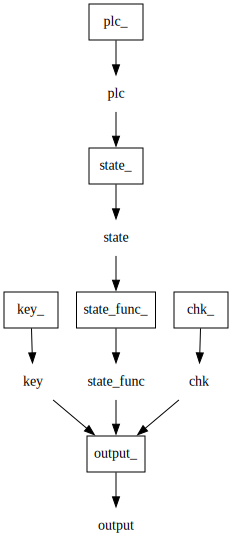

In [39]:
def consume_iterable(iterable):
    for _ in iterable:
        pass


def mk_iterable_reader(iterable):
    return iter(iterable).__next__


def mk_slabs_solution(
    chks_reader, plc_reader, keys_reader, store,
    mk_recorder: Callable[[MutableMapping], Any] = RecordingSwitchBoard,
):
    mk_recorder = RecordingSwitchBoard

    recorder = mk_recorder(store)
    transition = transitioner.reset().transition

    from meshed import Slabs

    return Slabs(
        chk=chks_reader,
        plc=plc_reader,
        key=keys_reader,
        state = lambda plc: transition(plc),
        state_func = lambda state: getattr(recorder, state, None),
        output=lambda state_func, key, chk: state_func(key, chk) if state_func is not None else None,
    )


slabs = mk_slabs_solution(
    *map(mk_iterable_reader, [audio_chks, plc_values, keys]), 
    store, mk_recorder=RecordingSwitchBoard
)
slabs.dot_digraph()

In [16]:
def conditional_recording_4(
    audio_chks, plc_values, keys, store, 
    mk_recorder: Callable[[MutableMapping], Any] = RecordingSwitchBoard,
):

    slabs = mk_slabs_solution(
        *map(mk_iterable_reader, [audio_chks, plc_values, keys]), 
        store, mk_recorder
    )
    consume_iterable(slabs)


# Example usage:
store = dict()
test_conditional_recording(conditional_recording_4, store_factory=lambda: store)
pprint(store)


{1: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
 5: [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
 10: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]}


### Reusable component: SwitchCase

In [42]:
from dataclasses import dataclass
from typing import Mapping, Callable, Any

from i2 import Sig, ch_names

Case = Any
Cases = Mapping[Case, Callable]

@dataclass
class SimpleSwitchCase:
    """A functional implementation of thw switch-case control flow.
    Makes a callable that takes two arguments, a case and an input.
    
    >>> f = SimpleSwitchCase({'plus_one': lambda x: x + 1, 'times_two': lambda x: x * 2})
    >>> f('plus_one', 2)
    3
    >>> f('times_two', 2)
    4
    """
    cases: Mapping[Case, Callable]

    def __call__(self, case, input):
        func = self.cases.get(case, None)
        if func is None: 
            raise ValueError(f"Case {case} not found.")
        return func(input)
    

def mk_simple_switch_case(
        cases: Cases, *, name: str = None, case_name: str = None, input_name: str = None
    ):
    """
    Makes a simple switch-case function, with optional naming control.
    """
    switch_case_func = SimpleSwitchCase(cases)
    switch_case_func = ch_names(
        switch_case_func, **dict(case=case_name, input=input_name)
    )
    if name is not None:
        switch_case_func.__name__ = name
    return switch_case_func



In [188]:
def mk_recorder_switch(
        store, 
        *,
        mk_recorder: Callable[[MutableMapping], Any] = RecordingSwitchBoard
):
    recorder = mk_recorder(store)
    return mk_simple_switch_case(
        {
            "start": recorder.start,
            "resume": recorder.resume,
            "stop": recorder.stop,
            "waiting": lambda x: None,
        },
        name="recorder_switch",
        case_name="state",
        input_name="chk",
    )



In [196]:
store = dict()
# f = mk_recorder_switch(store)
# f
# i2.Sig(f.start)
g = RecordingSwitchBoard({}).stop
i2.Sig(g)
# f.func('start', 1)

<Sig (key, chk)>

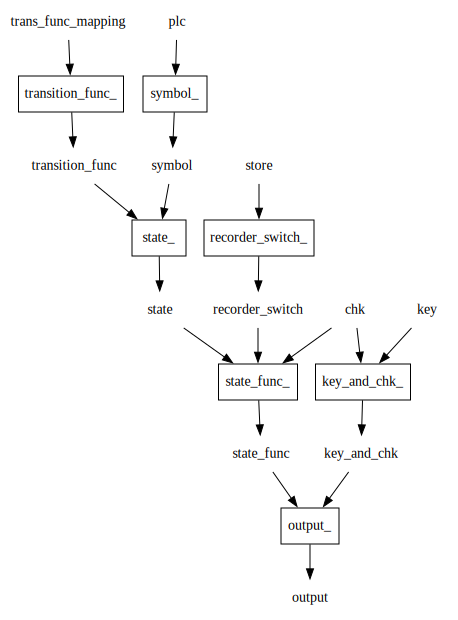

In [77]:
import i2

def mk_transition_func(
        trans_func_mapping, initial_state, #symbol_var_name: str,
    ):
    recording_state_transition_func = mapping_to_transition_func(
        trans_func_mapping,
        strict=False,
    )
    transitioner = BasicAutomata(
        transition_func=recording_state_transition_func,
        state=initial_state,
    )

    # @i2.ch_names(symbol=symbol_var_name)
    def transition(symbol):
        return transitioner.transition(symbol)
    
    return transition

from meshed import DAG

dag = DAG.from_funcs(
    recorder_switch = lambda store: mk_recorder_switch(store),
    transition_func=lambda trans_func_mapping: mk_transition_func(trans_func_mapping, "waiting"),
    symbol=lambda plc: plc,
    state=lambda transition_func, symbol: transition_func(symbol),
    key_and_chk=lambda key, chk: (key, chk),
    state_func=lambda recorder_switch, state, key_and_chk: recorder_switch(state, key_and_chk),
    output=lambda state_func, key_and_chk: state_func(*key_and_chk) if state_func is not None else None,
)

dag.dot_digraph()


In [ ]:
import creek.multi_streams

In [79]:
store = dict()
trans_func_mapping = {
        ("waiting", 1): "start",
        ("start", 0): "resume",
        ("start", 1): "stop",
        ("resume", 1): "stop",
        ("stop", 0): "waiting",
        ("stop", 1): "start",
}

my_dag = dag.partial(store=store, trans_func_mapping=trans_func_mapping)
my_dag.dot_digraph()
print(i2.Sig(my_dag))

for chk, plc, key in zip(audio_chks, plc_values, keys):
    my_dag(chk=chk, plc=plc, key=key)  # Careful: use keyword arguments! (Order not consistent.)

(plc, chk, key, store={}, trans_func_mapping={('waiting', 1): 'start', ('start', 0): 'resume', ('start', 1): 'stop', ('resume', 1): 'stop', ('stop', 0): 'waiting', ('stop', 1): 'start'})


TypeError: RecordingSwitchBoard.start() missing 1 required positional argument: 'chk'

In [80]:
chk, plc, key

([5, 6, 7, 8, 9], 1, 1)

In [145]:
def mk_node_container(dag, scope=()):
    from types import SimpleNamespace
    return SimpleNamespace(
        **{f.name: f.func for f in dag.func_nodes}, **dict(scope)
    )

scope = {}
n = mk_node_container(my_dag, scope)


In [146]:
scope = dict(chk=chk, plc=plc, key=key)
n = mk_node_container(my_dag)
it = enumerate(my_dag.call_on_scope_iteratively(scope))

In [150]:
i, _ = next(it)
print(f"i = {i}")
print(f"{my_dag.func_nodes[i]}")
print(f"{list(scope)}")
print(f"Next: {my_dag.func_nodes[i + 1]}")


i = 3
FuncNode(transition_func,symbol -> state_ -> state)
['chk', 'plc', 'key', 'recorder_switch', 'transition_func', 'symbol', 'state']
Next: FuncNode(recorder_switch,state,chk -> state_func_ -> state_func)


In [172]:
n = mk_node_container(my_dag, scope)
i2.Sig(n.recorder_switch)
n.recorder_switch
# n.state_func_(n.recorder_switch, n.state, n.chk)  # recorder_switch, state, chk


TypeError: RecordingSwitchBoard.start() missing 1 required positional argument: 'chk'

In [165]:
%pdb

Automatic pdb calling has been turned OFF


In [156]:
n.state

'start'

In [161]:
i2.Sig(n.recorder_switch.func)
n.recorder_switch.func('start', )

<Sig (case, input)>

In [154]:
n.recorder_switch

<i2.Wrap recorder_switch(state, chk)>

In [84]:
scope['recorder_switch']

<i2.Wrap recorder_switch(state, chk)>

In [63]:
f = my_dag.debugger()
it = f(chk=chk, plc=plc, key=key)  # Careful: use keyword arguments! (Order not consistent.)

In [67]:
t = next(it)
t

3 --------------------------------------------------------------
	func_node=FuncNode(transition_func,symbol -> state_ -> state)
	scope={'plc': 1, 'chk': [5, 6, 7, 8, 9], 'key': 1, 'store': {}, 'trans_func_mapping': {('waiting', 1): 'start', ('start', 0): 'resume', ('start', 1): 'stop', ('resume', 1): 'stop', ('stop', 0): 'waiting', ('stop', 1): 'start'}, 'recorder_switch': <i2.Wrap recorder_switch(state, chk)>, 'transition_func': <function mk_transition_func.<locals>.transition at 0x16d767010>, 'symbol': 1, 'state': 'start'}


'start'

In [72]:
tf = mk_transition_func(trans_func_mapping, "waiting")


In [75]:
my_dag.func_nodes

[FuncNode(store -> recorder_switch_ -> recorder_switch),
 FuncNode(trans_func_mapping -> transition_func_ -> transition_func),
 FuncNode(plc -> symbol_ -> symbol),
 FuncNode(transition_func,symbol -> state_ -> state),
 FuncNode(recorder_switch,state,chk -> state_func_ -> state_func),
 FuncNode(key,chk -> key_and_chk_ -> key_and_chk),
 FuncNode(state_func,key_and_chk -> output_ -> output)]

In [74]:
my_dag.func_nodes[3].func(tf, 1)

'start'

In [51]:
%pdb

Automatic pdb calling has been turned OFF


In [28]:
dag_with_readers = dag + DAG.from_funcs(
    chk = lambda chks_reader: chks_reader(),
    plc = lambda plc_reader: plc_reader(),
    key = lambda keys_reader: keys_reader(),
)
dag_with_readers.dot_digraph()

i2.Sig(dag_with_readers)

<Sig (store, trans_func_mapping, chks_reader, plc_reader, keys_reader)>

In [30]:
from meshed import Slabs

store = dict()
trans_func_mapping = {
        ("waiting", 1): "start",
        ("start", 0): "resume",
        ("start", 1): "stop",
        ("resume", 1): "stop",
        ("stop", 0): "waiting",
        ("stop", 1): "start",
}



chks_reader = mk_iterable_reader(audio_chks)
plc_reader = mk_iterable_reader(plc_values)
keys_reader = mk_iterable_reader(keys)

slabs = Slabs.from_func_nodes(
    dag_with_readers
)


In [31]:
next(slabs)

TypeError: missing a required argument: 'store'

In [ ]:
from creek.automatas import BasicAutomata, MappingTransitionFunc

store = dict()
mk_recorder = RecordingSwitchBoard
recorder = mk_recorder(store)

def waiting(key, chk):
    pass

trans_func = MappingTransitionFunc(
    {
        (waiting, 1): recorder.start,
        ("start", 0): "resume",
        ("start", 1): "stop",
        ("resume", 1): "stop",
        ("stop", 0): "waiting",
        ("stop", 1): "start",
    },
    strict=False,
)

trans_func = trans_func.map_states(
    {
        "waiting": lambda key, chk: None,
        "start": recorder.start,
        "resume": recorder.resume,
        "stop": recorder.stop,
    }
)

transitioner = BasicAutomata(
    transition_func=trans_func,
    state="waiting",
)

state_sequence = list(transitioner('waiting', plc_values))
state_sequence

# Appendices

## Diagrams

In [15]:
# pip install kroki
%load_ext kroki

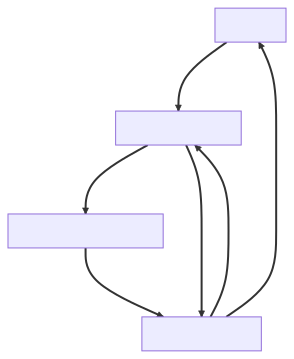

In [46]:
%%kroki mermaid
flowchart TD
   nothing -->|1| start_recording
   start_recording -->|0| continue_recording
   start_recording -->|1| end_recording
   continue_recording -->|1| end_recording
   end_recording -->|0| nothing
   end_recording -->|1| start_recording

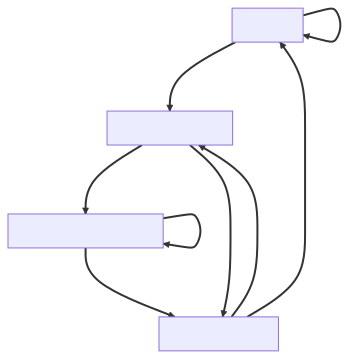

In [48]:
%%kroki mermaid
flowchart TD
   nothing -->|0| nothing
   nothing -->|1| start_recording
   start_recording -->|0| continue_recording
   start_recording -->|1| end_recording
   continue_recording -->|0| continue_recording
   continue_recording -->|1| end_recording
   end_recording -->|0| nothing
   end_recording -->|1| start_recording

<script src="https://cdn.jsdelivr.net/npm/mermaid/dist/mermaid.min.js">

This 
```html
<div class="mermaid">
graph TD;
A-->B;
A-->C;
B-->D;
C-->D;
</div>
```

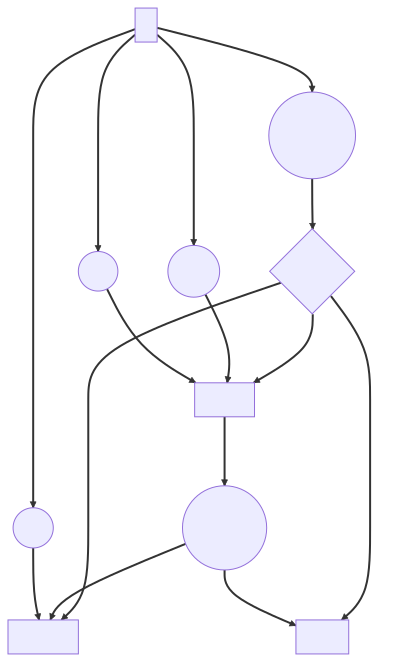

In [17]:
%%kroki mermaid
flowchart TD
    * --> key((key))
    * --> chk((chk))
    * --> command((command))
    * --> store((store))

    command --> state{state}
    state -->|open| create
    state -->|resume| append
    state -->|close| close

    store --> create
    key --> create
    create --> sequence((sequence))
    
    sequence --> append
    chk --> append
    sequence --> close
    